In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import re

# 1. Titanic best working Classifier
[原文地址](https://www.kaggle.com/sinakhorami/titanic-best-working-classifier)

## 1.1 介绍
本文是我关于`Titanic`数据集的第一次尝试。

## 1.2 数据的概括
首先我们对数据的整体情况进行初步的分析。我们使用Pandas读取数据：

In [2]:
train = pd.read_csv('data/train.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('data/test.csv' , header = 0, dtype={'Age': np.float64})

full_data = [train, test]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


数据集包含12个列，即12个字段。其中有部分是数值类型，也有部分是字符串类型。数据集中的某些行包含null值。

## 1.3 特征工程
接下来依次分析每个字段。

`PassengerId`是旅客的ID，根据经验这个特征应该与预测无关；`Survived`是旅客的获救情况，是我们将要预测的值，其中`0`表示死亡，`1`表示获救。

### 1.3.1 Pclass
`Pclass`，A proxy for socio-economic status，即旅客的社会经济地位，包含以下值：
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

`Pclass`没有null值并且是数值类型。我们统计一下各等级旅客的获救情况：

In [3]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


### 1.3.2 Sex
`Sex`表示旅客的性别，字段没有null值，是字符串类型，包括两个值：`male`和`female`。我们统计一下不同个性别的旅客的获救情况：

In [4]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


### 1.3.3 SibSp and Parch
这两个字段用来定义家庭关系，字段没有null值，并且是数值类型，含义如下：
- sibsp: 堂兄弟/妹个数
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)
- parch: 父母与小孩个数
    - Parent = mother, father
    - Child = daughter, son, stepdaughter, stepson
    - Some children travelled only with a nanny, therefore parch=0 for them.

我们可以通过这两个字段合成旅客在船上的家庭成员的人数，之后统计不同家庭成员数的家庭的获救状况：

In [5]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


合成字段看起来似乎有效果。让我们更近一步，统计一下旅客是否单身一人在船上：

In [6]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


可以看到，`IsAlone`对旅客是否获救产生了影响。

### 1.3.4 Embarked
`Embarked`特征表示登船的港口，这个字段是有null值的，我们使用最多的值来填充null值：

In [7]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### 1.3.5 Fare
`Fare`特征表示票价，特征值有缺失，我们使用中位数来填充。我们不关心具体的票价，而是将票价分割为4个等级，之后按等级统计票价对旅客是否获救的影响：

In [8]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean()

,CategoricalFare,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


### 1.3.5 Age
`Age`表示旅客的年龄，从之前的信息看到这个特征的值存在大量的缺失。我们使用一个随机数来填充，随机数的范围在$mean-std$到$mean+std$之间。之后我们将年龄分为5段来统计获救情况：

In [9]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)
train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,CategoricalAge,Survived
0,"(-0.08, 16.0]",0.522936
1,"(16.0, 32.0]",0.346154
2,"(32.0, 48.0]",0.388462
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


### 1.3.6 Name
通常认为名字对预测没有影响。但是仔细观察数据集的记录，我们发现名字当中有`Title`。我们将这个信息提取出来：

In [10]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


我们将`Title`和`Sex`进行组合，之后进行分类，再对各个分类进行统计：

In [11]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


## 1.4 数据清洗
完成关键特征的整理之后，我们将所有非数值型的字段转换为数值型，再从数据集中删除对预测没有意义的特征：

In [12]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

train.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,0,3,1,1,0,0,0,1
1,1,1,0,2,3,1,0,3
2,1,3,0,1,1,0,1,2
3,1,1,0,2,3,0,0,3
4,0,3,1,2,1,0,1,1
5,0,3,1,2,1,2,1,1
6,0,1,1,3,3,0,1,1
7,0,3,1,0,2,0,0,4
8,1,3,0,1,1,0,0,3
9,1,2,0,0,2,1,0,3


从Pandas的DataFrame中提取`numpy.ndarray`作为模型的输入。之后我们就有了干净的数据用来构建模型了：

In [13]:
train_set = train.values
test_set = test.values

## 1.5 训练模型
我们训练多个分类器进行比较：

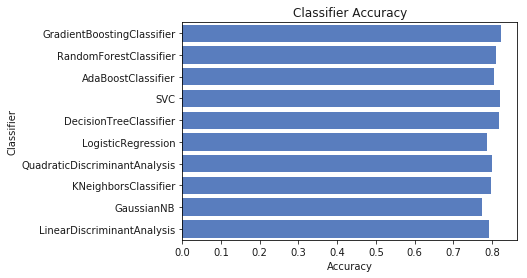

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train_set[0::, 1::]
y = train_set[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
plt.show()